# Run PeakVI - Trevino
----
Construct latent space and compute acessibility probabilities

# Preliminaries

## Dependecy notebooks

This notebooks depends on "notebooks/MG_trevino/MG_09-28-2021_Setting_up_data_for_PeakVI.ipynb".

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
# import standard packages
import numpy as np
import pandas as pd 
from scipy.io import mmread
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import scvi

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.4.0+gf8eb26b scanpy==1.7.2 anndata==0.7.6 numpy==1.20.0 numba==0.52.0 scipy==1.5.4 pandas==1.0.5 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 scvelo==0.2.3 pygam==0.8.0 matplotlib==3.2.2 seaborn==0.11.1


In [4]:
cr.logging.print_version_and_date()

Running CellRank 1.4.0+gf8eb26b, on 2022-01-16 08:17.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [5]:
Path='/vol/storage/projects/ATAC/data/MG_trevino'

In [6]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [7]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [8]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "satpathy_hematopoeisis", separate_dirs=True)
    print('Sucessfully imported scachepy. Expensive computations will be cached. ')
except ImportError:
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
    c = None
    
use_caching = c is not None
c

Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. 


## Set global parameters

Set some plotting parameters.

In [9]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [10]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

In [11]:
def del_from_obs(adata, keys):
    """Utility function to delete attributes from adata.obs"""
    keys = [key for key in keys if key in adata.obs.keys()]
    print(f"Removing {keys}")
    for key in keys:
        del adata.obs[key]

## Load the data

Load a pre-constructed AnnData object

In [20]:
adata = sc.read(f'{Path}/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 31304 × 657930
    obs: 'Cell_ID', 'Timepoint', 'Batch', 'Exp_Batch', 'Barcode', 'LSI_cluster', 'Internal_Name', 'UMAP1', 'UMAP2', 'clusters', 'Timepoints', 'day'
    var: 'chromosome', 'start', 'end', 'Peak_score', 'Peak_norm', 'name'
    obsm: 'X_umap_precomp'

## QC and Preprocessing

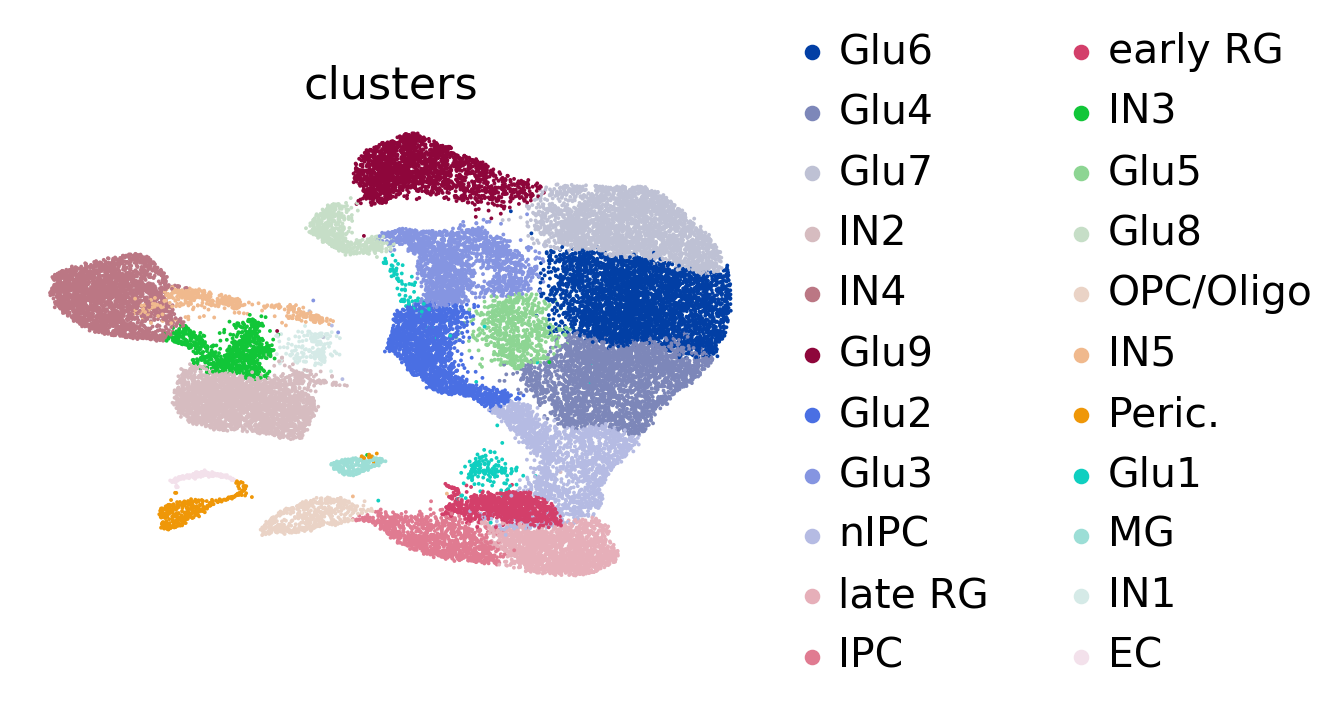

In [13]:
scv.pl.scatter(adata, c=['clusters'], legend_loc='right', basis='umap_precomp')

Filter to peaks at least expressed in 5% of the cells

In [21]:
print(adata.shape)

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.08)

# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(31304, 657930)


filtered out 627078 genes that are detected in less than 2504 cells


(31304, 30852)


In [26]:
print(adata.shape)

# compute the threshold: 5% of the cells
min_genes = int(adata.shape[1] * 0.05)

# in-place filtering of regions
sc.pp.filter_cells(adata, min_genes=min_genes)
print(adata.shape)

(31304, 52685)


filtered out 1030 cells that have less than 1053 genes expressed


(30274, 52685)


## Check signal in raw data

In [27]:
adata.obs['mean_raw_accessibility'] =  adata.X.mean(axis=1)

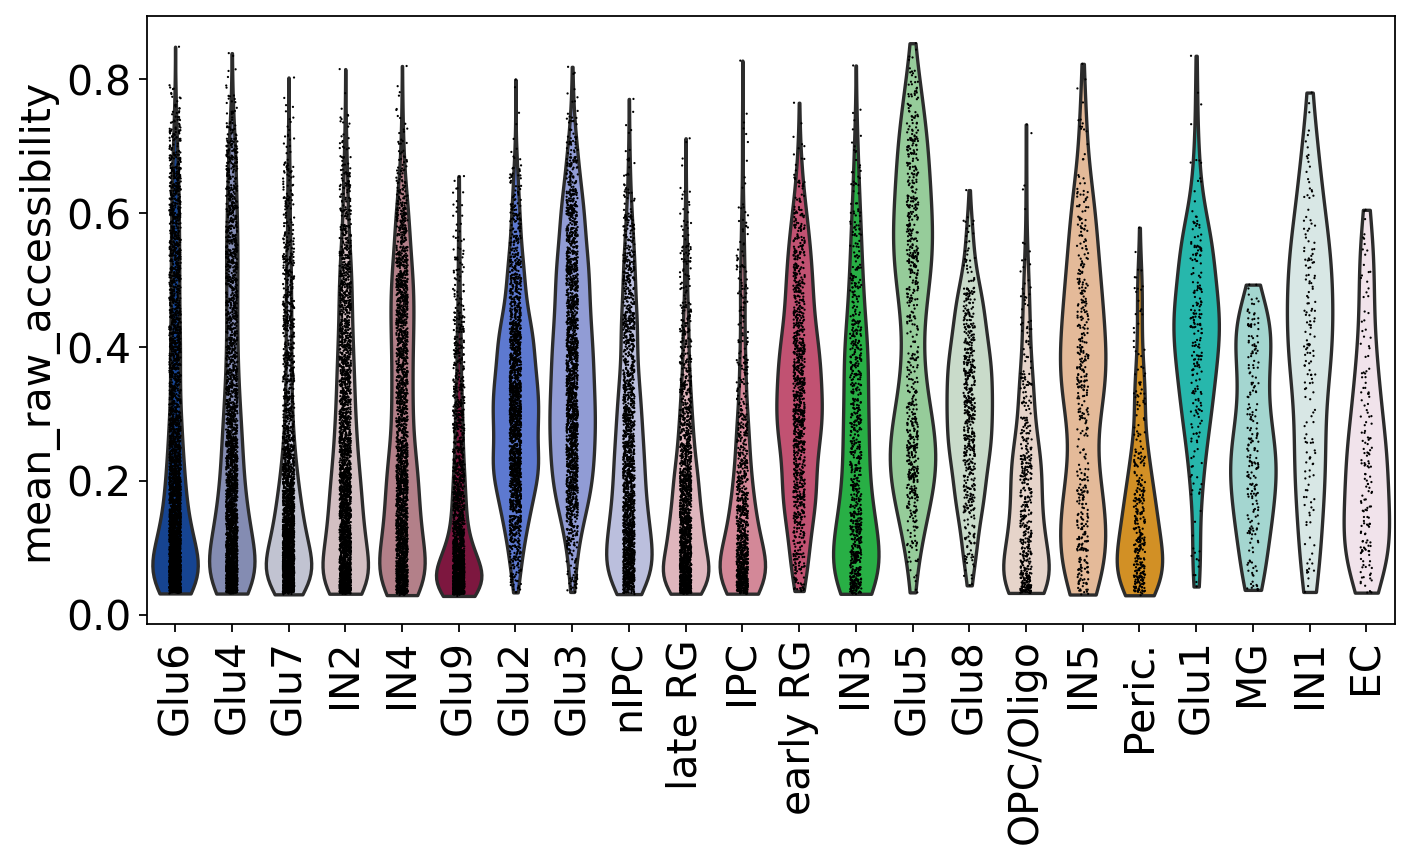

In [28]:
sc.pl.violin(adata, keys='mean_raw_accessibility', groupby='clusters', rotation=90, ax=plt.figure(None, (10, 5)).gca())

# Run PeakVI

## Set up the model

In [22]:
scvi.data.setup_anndata(adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 31304 cells, 30852 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


## Load / Train the model

Either train the model...

In [23]:
# Use GPUs to have acceptable runing times for this cell
pvi = scvi.model.PEAKVI(adata)
pvi.train()

#pvi.save(f"{Path}/trained_model_global_no_batch", overwrite=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 173/500:  35%|███▍      | 173/500 [27:27<51:54,  9.53s/it, loss=1.71e+08, v_num=1]  


or load it from file:

In [9]:
pvi = scvi.model.PEAKVI.load(f"{Path}/trained_model", adata)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 31304 cells, 52685 vars, 13       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


## Check the latent space

In [24]:
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent

print(latent.shape)

(31304, 13)


In [11]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_PeakVI")

# compute the umap
sc.tl.umap(adata, random_state=0)

computing neighbors
    finished (0:00:14)
computing UMAP
    finished (0:00:15)


/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


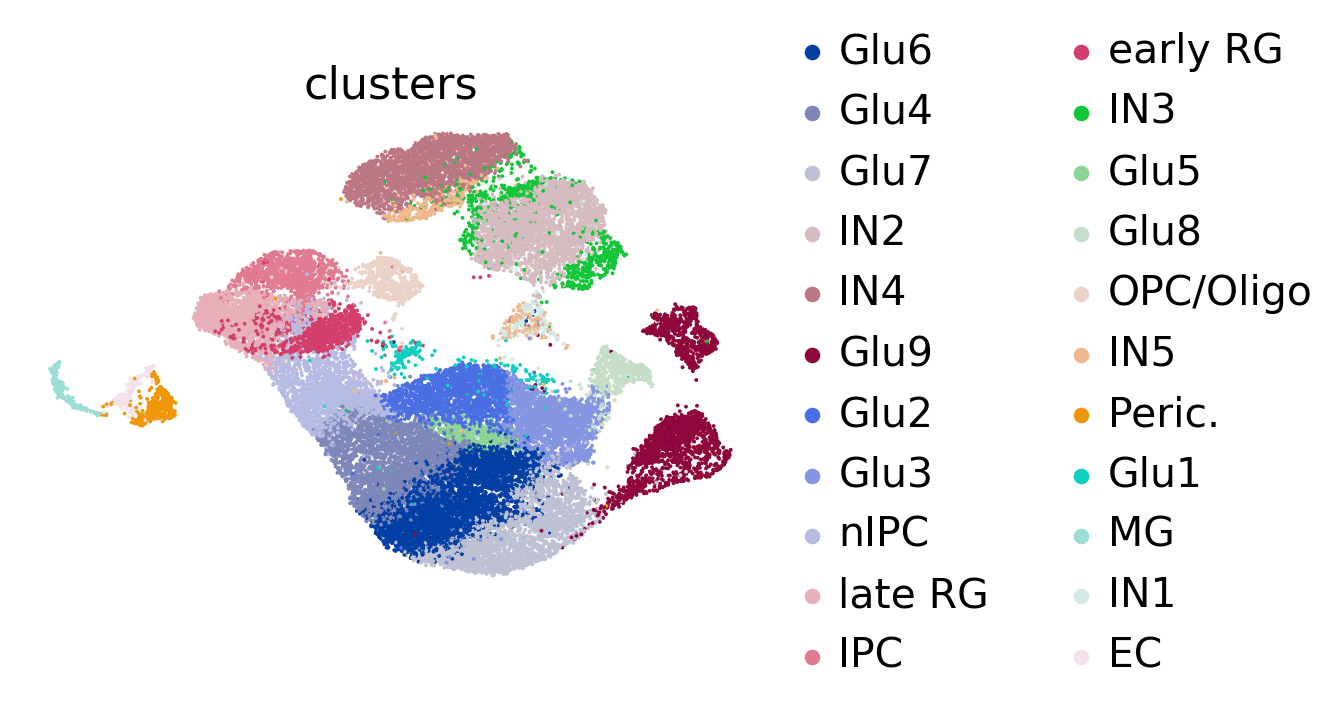

In [36]:
scv.pl.scatter(adata, color='clusters', legend_loc='right')

/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


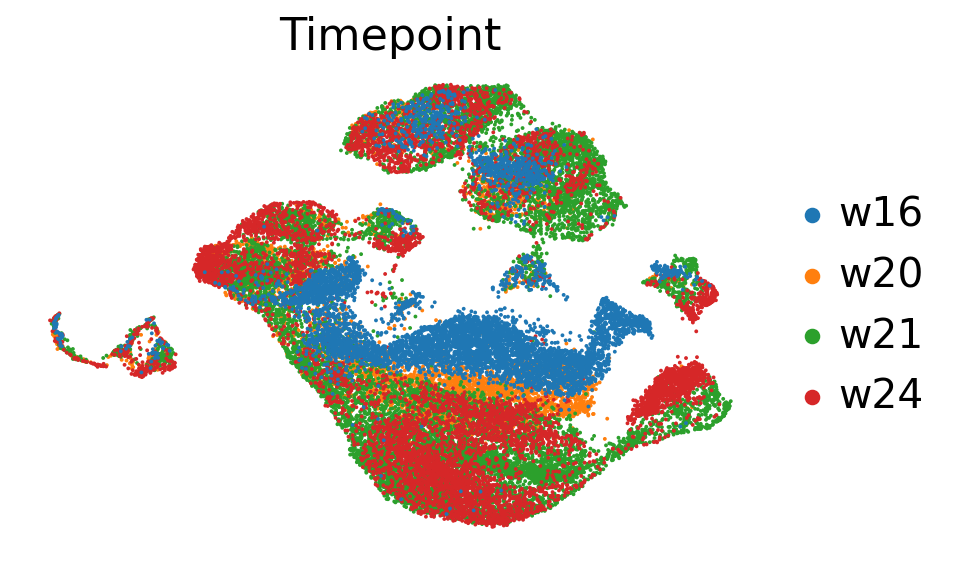

In [16]:
scv.pl.scatter(adata, color='Timepoint', legend_loc='right')

In [38]:
adata.obs['library_size_factors'] = pvi.get_library_size_factors(adata)

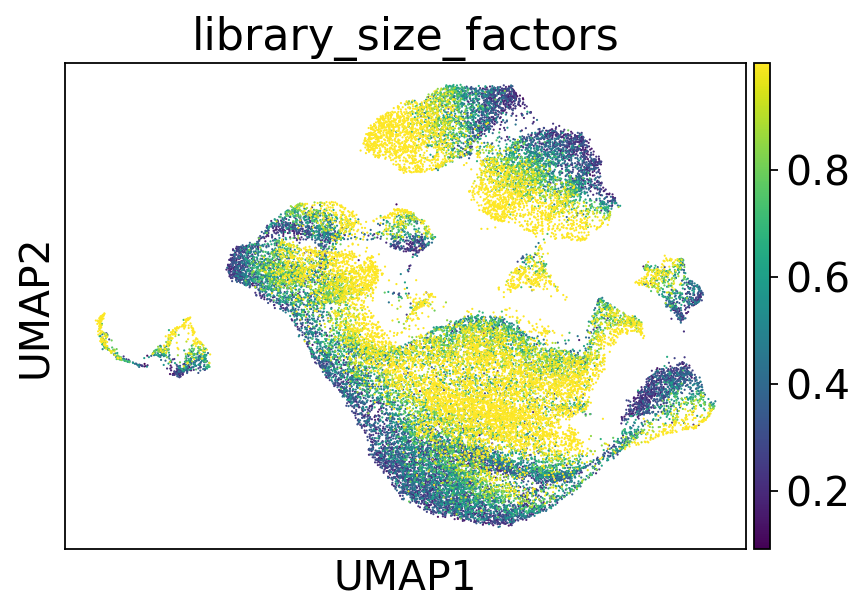

In [39]:
sc.pl.umap(adata, color='library_size_factors')

## Let's check aggregated acessibility

In [12]:
adata.layers['accessibility_estimates'] = pvi.get_accessibility_estimates(adata)

Try different aggregation strategies

In [13]:
adata.obs['mean_accessibility'] =  adata.layers['accessibility_estimates'].mean(axis=1)
adata.obs['median_accessibility'] =  np.median(adata.layers['accessibility_estimates'], axis=1)
adata.obs['summed_accessibility'] =  adata.layers['accessibility_estimates'].sum(axis=1)

In [15]:
adata

AnnData object with n_obs × n_vars = 31304 × 52685
    obs: 'Cell_ID', 'Timepoint', 'Batch', 'Exp_Batch', 'Barcode', 'LSI_cluster', 'Internal_Name', 'UMAP1', 'UMAP2', 'clusters', 'Timepoints', 'day', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'mean_accessibility', 'median_accessibility', 'summed_accessibility'
    var: 'chromosome', 'start', 'end', 'Peak_score', 'Peak_norm', 'name', 'n_cells'
    uns: 'clusters_colors', '_scvi', 'neighbors', 'umap'
    obsm: 'X_umap_precomp', 'X_PeakVI', 'X_umap'
    layers: 'accessibility_estimates'
    obsp: 'distances', 'connectivities'

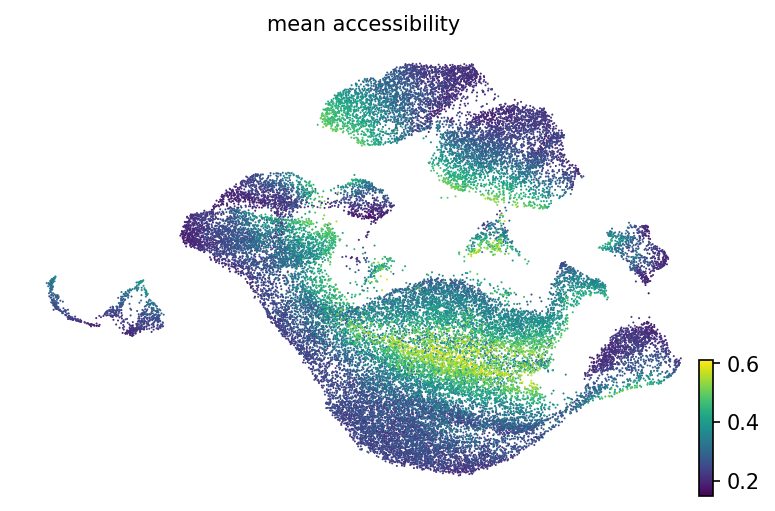

In [14]:
scv.pl.scatter(adata, c='mean_accessibility', basis='X_umap', dpi=150)

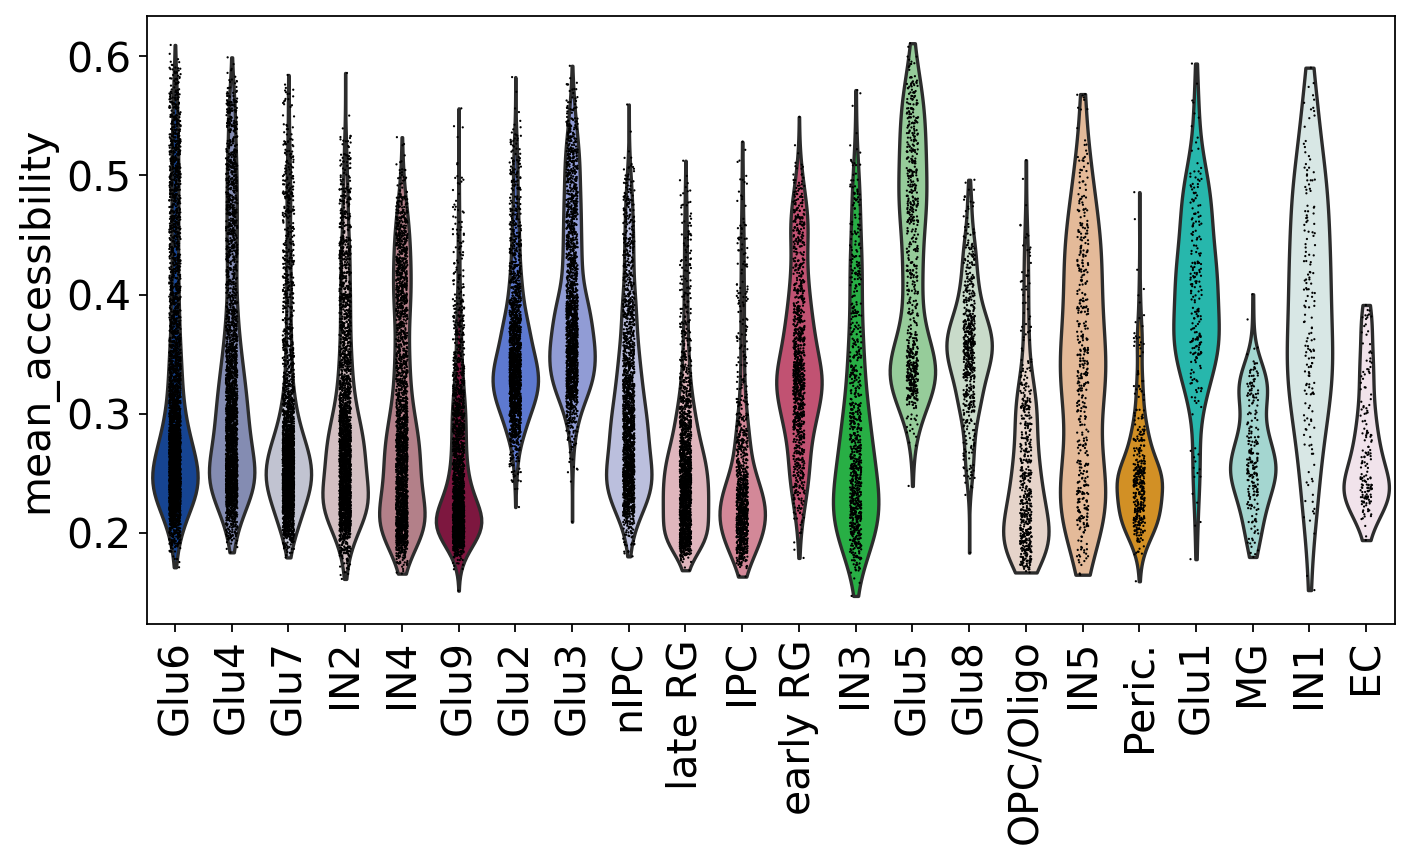

In [43]:
sc.pl.violin(adata, keys='mean_accessibility', groupby='clusters', rotation=90, ax=plt.figure(None, (10, 5)).gca())

Let's restrict this to some Glu-cells 

In [44]:
island = ['Glu1','Glu2','Glu3']
b_mask = np.in1d(adata.obs['clusters'], island)

/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


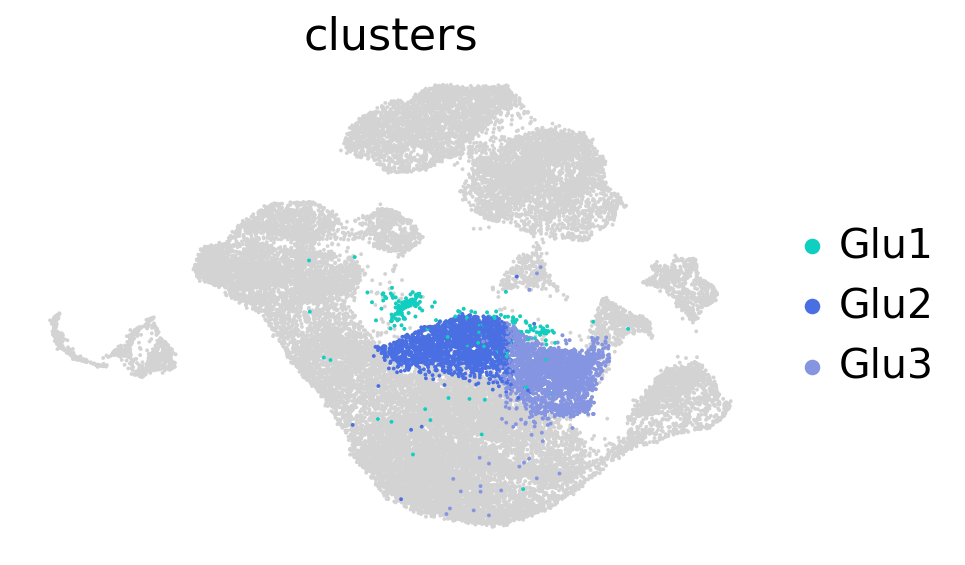

In [45]:
scv.pl.scatter(adata, c=['clusters'], groups=island, legend_loc='right')

/vol/storage/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


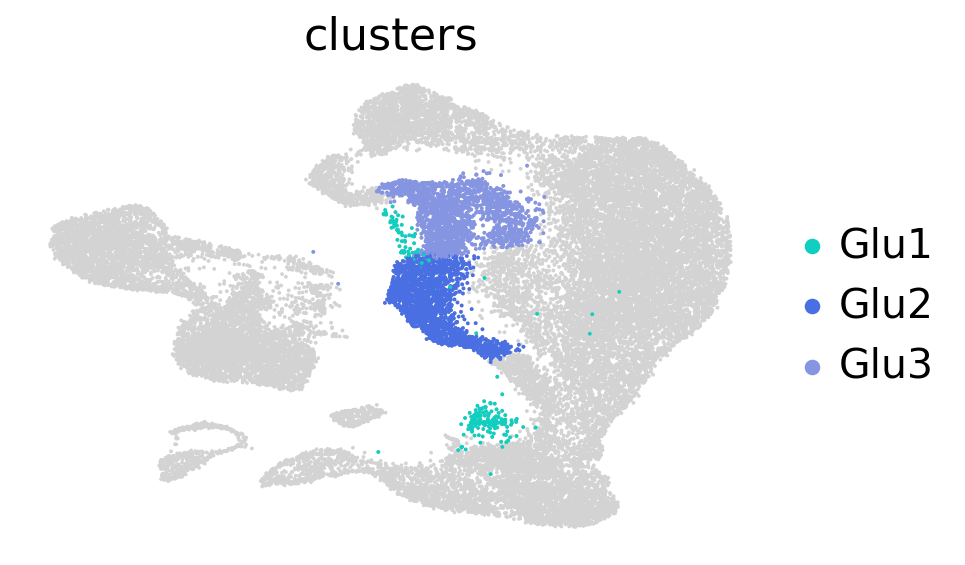

In [46]:
scv.pl.scatter(adata, basis='umap_precomp', c=['clusters'], groups=island, legend_loc='right')

## Save the new adata as adataPV

In [47]:
adata

AnnData object with n_obs × n_vars = 31304 × 52685
    obs: 'Cell_ID', 'Timepoint', 'Batch', 'Exp_Batch', 'Barcode', 'LSI_cluster', 'Internal_Name', 'UMAP1', 'UMAP2', 'clusters', 'Timepoints', 'day', 'mean_raw_accessibility', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'library_size_factors', 'mean_accessibility', 'median_accessibility', 'summed_accessibility'
    var: 'chromosome', 'start', 'end', 'Peak_score', 'Peak_norm', 'name', 'n_cells'
    uns: 'clusters_colors', '_scvi', 'neighbors', 'umap', 'Timepoint_colors'
    obsm: 'X_umap_precomp', 'X_PeakVI', 'X_umap'
    layers: 'accessibility_estimates'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.write("/vol/storage/projects/ATAC/data/MG_trevino/adataPV.h5ad", compression='gzip')

## Construct a small PeakVI AnnData object

In [51]:
import anndata
adata=anndata.AnnData(X=adata.obsm['X_PeakVI'], obs=adata.obs, obsm=adata.obsm)

adata.write("/vol/storage/projects/ATAC/data/MG_trevino/adataPV_X_.h5ad", compression='gzip')